The segmentation of lung structures is very challenging problem because homogeneity is not present in the lung region, similar densities in the pulmonary structures, different scanners and scanning protocols. The segmented lungs can be further used to find the lung nodule candidates and regions of interest which may help in classification of the CT Scan. Finding the lung nodule regions is a very hard problem because there are nodules that are attached to the blood vessels or at the boundary of the lung region. The lung nodule candidates can be further used for classification by cutting 3D voxels around them and passing it through a 3D CNNs which can be trained on LUNA16 dataset. The LUNA 16 dataset has the location of the nodules in each CT Scan thus will be useful for training the classifier. 

In this tutorial, we will first segment the lungs and then find the region of interest in the CT Scans.

Please upvote or leave a comment, if you liked the tutorial.

**Reading a CT Scan**
-----------------
Each CT Scan consists of multiple 2D slices which are provided in a DICOM format. At first, I will read the random dicom file of a CT Scan. After reading the image file, we will update the intensity values of -2000 with 0 because they are the pixels that fall outside of the scanner bounds.

In [1]:
import pydicom
from pydicom.data import get_testdata_file
filename = get_testdata_file("rtplan.dcm")
ds = pydicom.dcmread(filename)  # plan dataset
ds.PatientName

filename = "../data/LIDC-IDRI/LIDC-IDRI-0001/1-001.dcm"
ds = pydicom.dcmread(filename)  # plan dataset

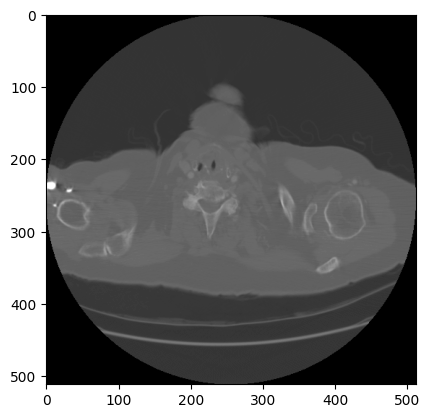

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.misc
# import dicom

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
# print(check_output(["ls", "./archive/images/images"]).decode("utf8"))

# # Any results you write to the current directory are saved as output.
# lung = dicom.read_file('../input/sample_images/00cba091fa4ad62cc3200a657aeb957e/38c4ff5d36b5a6b6dc025435d62a143d.dcm')
lung = pydicom.read_file("../data/LIDC-IDRI/LIDC-IDRI-0001/1-001.dcm")

slice = lung.pixel_array
slice[slice == -2000] = 0
plt.imshow(slice, cmap=plt.cm.gray)

Now we will read all the dicom slices for a scan and then stack them with respect to their Instance Number to get the 3D Lung CT Scanned Image.

In [3]:
def read_ct_scan(folder_name):
        # Read the slices from the dicom file
        # slices = [pydicom.read_file(folder_name + filename) for filename in os.listdir(folder_name)]
        slices = []
        for i, file in enumerate(os.listdir(folder_name)):
            # ignore .xml file
            if file.endswith('.xml'): continue
            filePath = os.path.join(folder_name, file)
            slice = pydicom.read_file(filePath)
            slices.append(slice)

        
        # Sort the dicom slices in their respective order
        slices.sort(key=lambda x: int(x.InstanceNumber))
        
        # Get the pixel values for all the slices
        slices = np.stack([s.pixel_array for s in slices])
        slices[slices == -2000] = 0
        return slices

In [4]:
ct_scan = read_ct_scan("../data/LIDC-IDRI/LIDC-IDRI-0001/") 

Now we will plot a few more images of the slices using the *plot_ct_scan* function.

In [5]:
def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 20) + 1, 4, sharex='col', sharey='row', figsize=(50, 50))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 20), int((i % 20) / 5)].axis('off')
        plots[int(i / 20), int((i % 20) / 5)].imshow(scan[i], cmap=plt.cm.bone) 

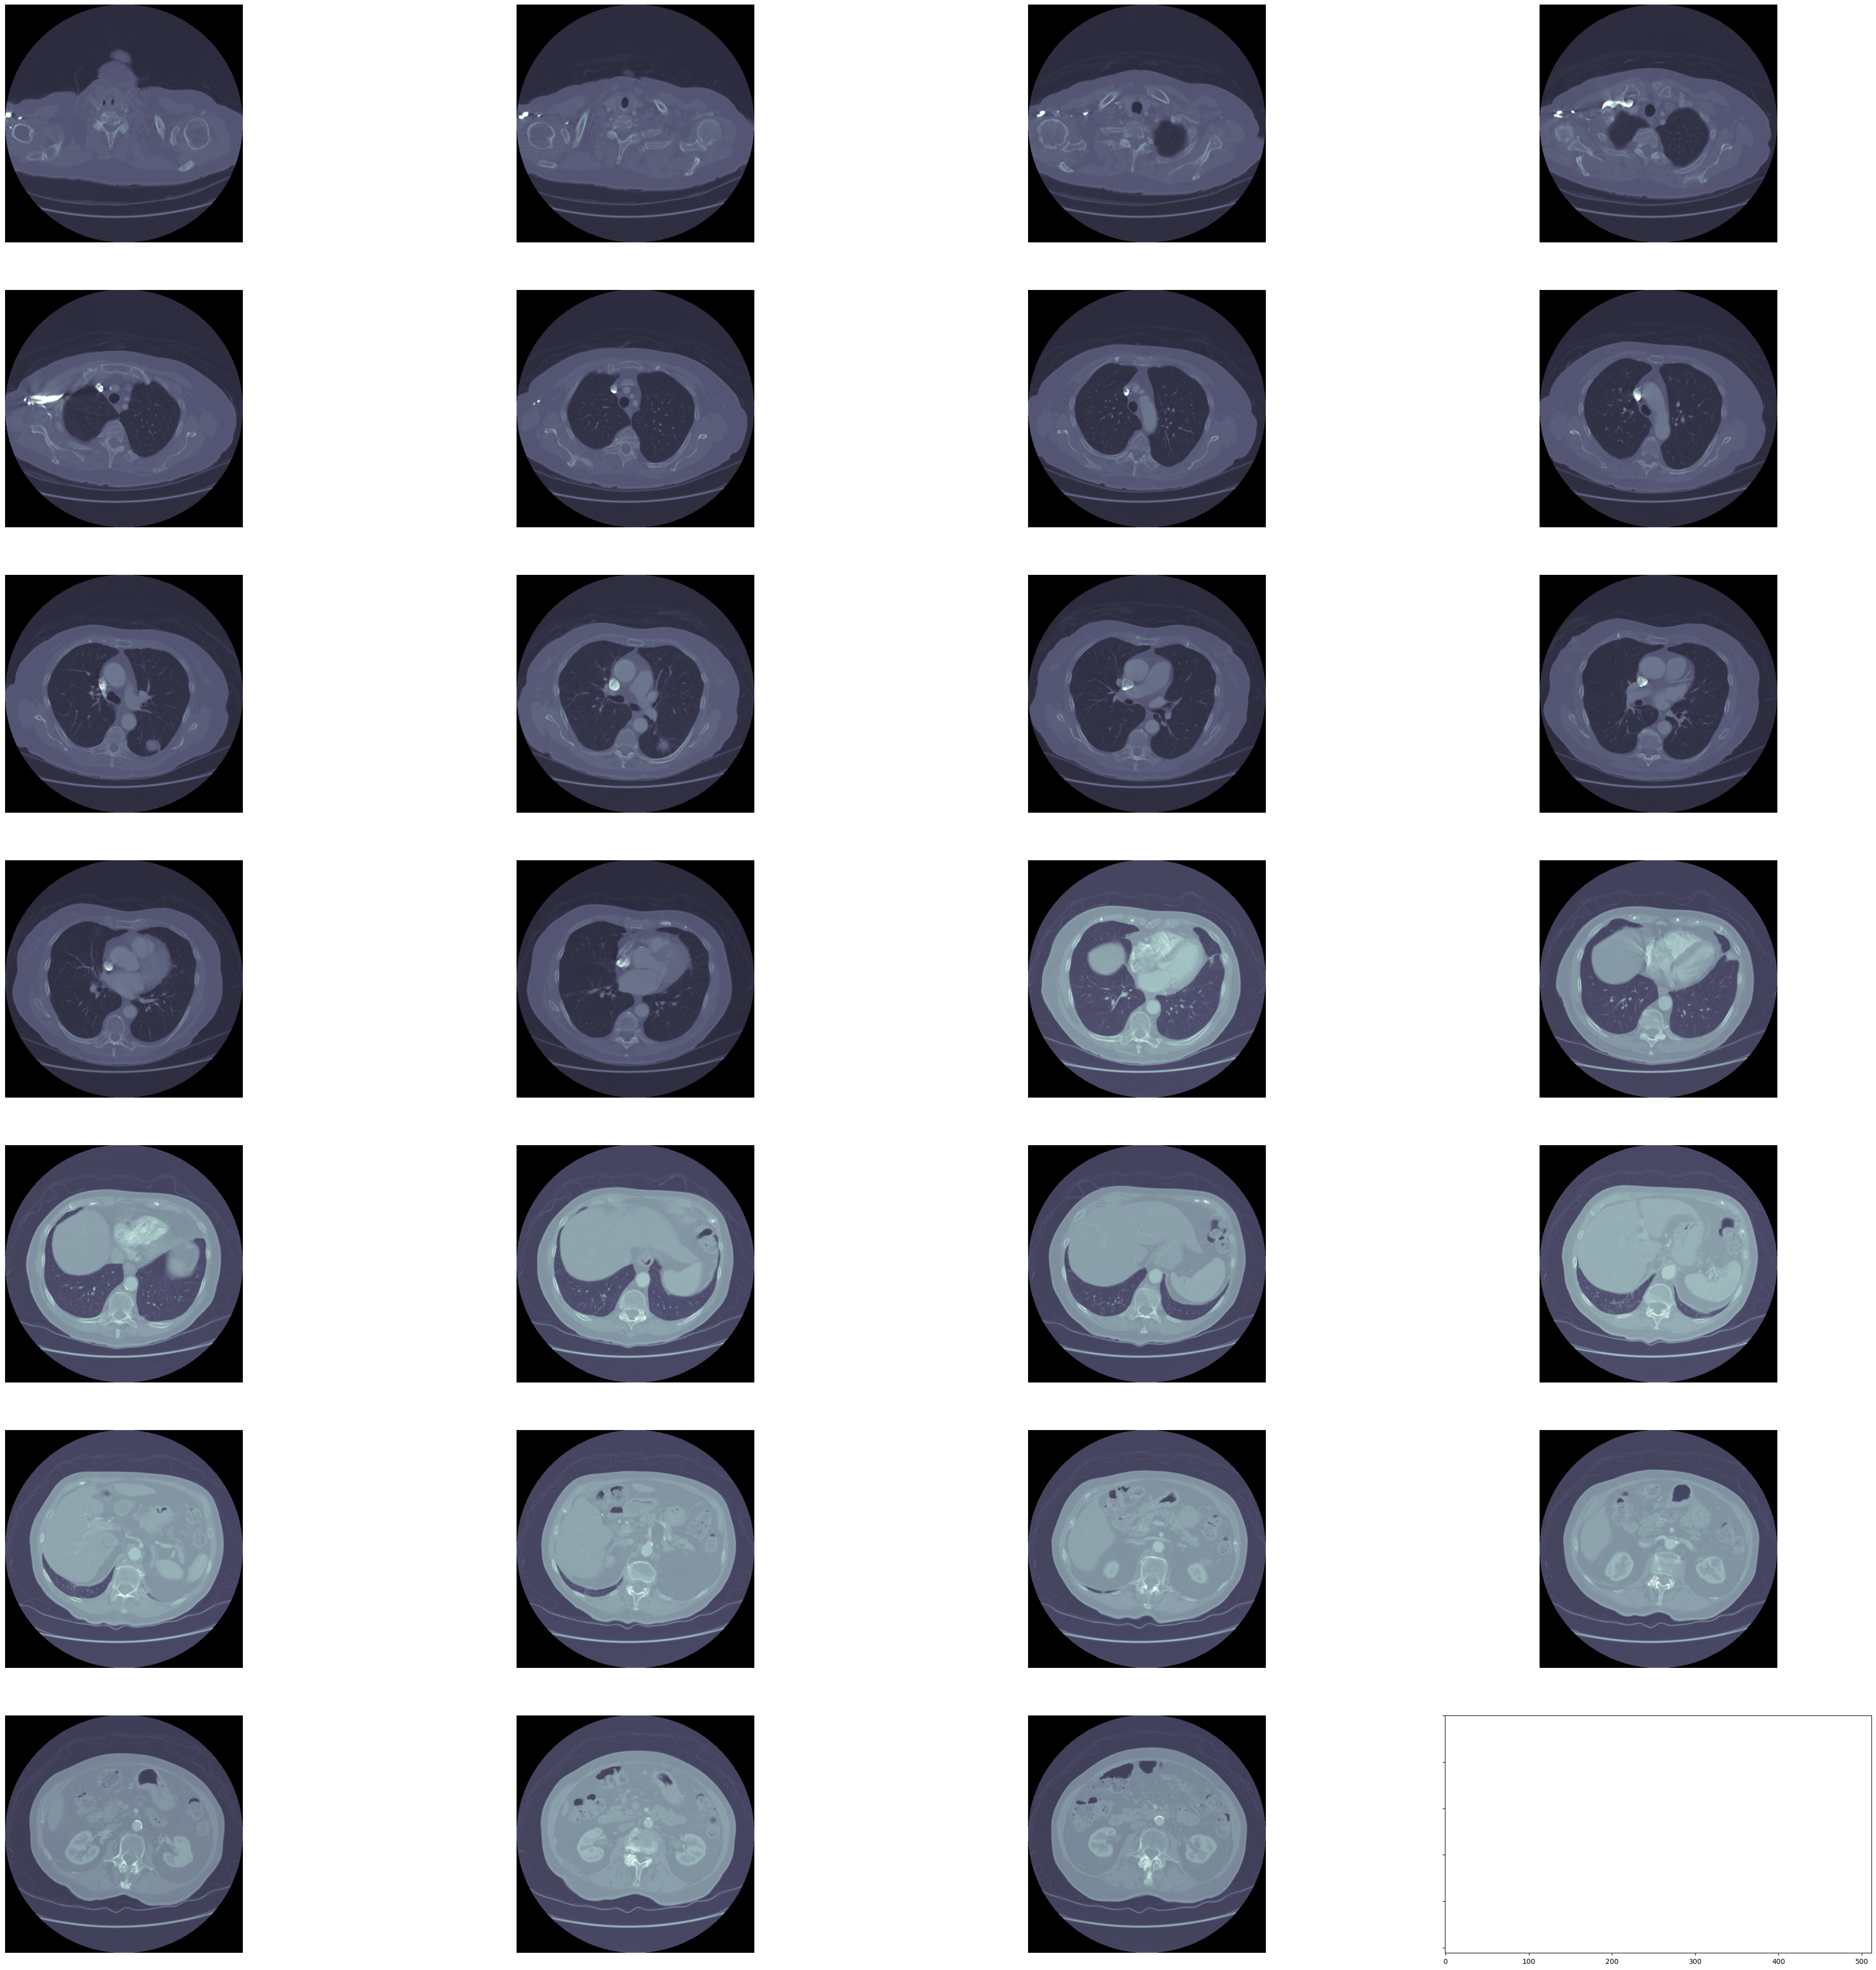

In [6]:
plot_ct_scan(ct_scan)

## Segmentation of Lungs ##
After reading the CT Scan, the first step in preprocessing is the segmentation of lung structures because it is obvious that the regions of interests lies inside the lungs. A threshold of 604(-400 HU) is used at all places because it was found in experiments that it works just fine. We segment lung structures from each slice of the CT Scan image.  

In [7]:
def get_segmented_lungs(im):
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    # Convert into a binary image. 
    # binary = im < 604
    binary = im < 300
    plt.imshow(binary, cmap=plt.cm.gray)
    
    # Remove the blobs connected to the border of the image
    cleared = clear_border(binary)

    # Label the image
    label_image = label(cleared)

    # Keep the labels with 2 largest areas
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0

    # Closure operation with disk of radius 12
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    
    selem = disk(10)
    binary = binary_closing(binary, selem)
    
    # Fill in the small holes inside the lungs
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)

    # Superimpose the mask on the input image
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    
    return im

In [8]:
def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([get_segmented_lungs(slice) for slice in ct_scan])

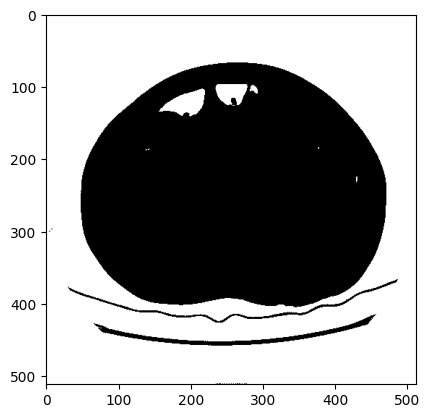

In [9]:
segmented_ct_scan = segment_lung_from_ct_scan(ct_scan)
# plot_ct_scan(segmented_ct_scan)

In [10]:
segmented_ct_scan[segmented_ct_scan < 604] = 0
# plot_ct_scan(segmented_ct_scan)

In [11]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces, _, _ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [12]:
from skimage.morphology import binary_dilation, binary_opening

selem = ball(2)
binary = binary_closing(segmented_ct_scan, selem)

label_scan = label(binary)

areas = [r.area for r in regionprops(label_scan)]
areas.sort()

for r in regionprops(label_scan):
    max_x, max_y, max_z = 0, 0, 0
    min_x, min_y, min_z = 1000, 1000, 1000
    
    for c in r.coords:
        max_z = max(c[0], max_z)
        max_y = max(c[1], max_y)
        max_x = max(c[2], max_x)
        
        min_z = min(c[0], min_z)
        min_y = min(c[1], min_y)
        min_x = min(c[2], min_x)
    if (min_z == max_z or min_y == max_y or min_x == max_x or r.area > areas[-3]):
        for c in r.coords:
            segmented_ct_scan[c[0], c[1], c[2]] = 0
    else:
        index = (max((max_x - min_x), (max_y - min_y), (max_z - min_z))) / (min((max_x - min_x), (max_y - min_y) , (max_z - min_z)))

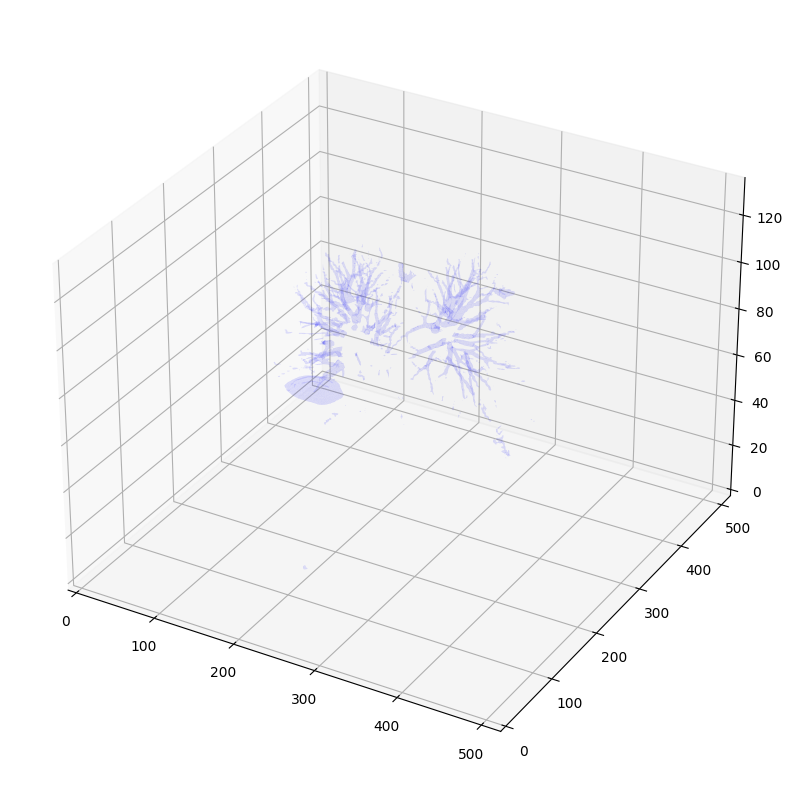

In [13]:
plot_3d(segmented_ct_scan, 604)
# plot_3d(segmented_ct_scan)